# Continuous Transformer
What if we take the Transformer to its continuous limit?

In [1]:
# Model settings
DIM = 1024
DEPTH = 6
VOCAB_SIZE = 256

# Training settings
BASE_LR = 3e-4
WEIGHT_DECAY = 0.01
BATCH_SIZE = 1
SEQ_LENGTH = int(8192/2)  # Character level
GRAD_CLIP = 1.0

# Checkpoint settings
CHECKPOINT_EVERY = 1000
PRINT_EVERY = 100

# Generation settings
GEN_LENGTH = int(300)
GEN_TEMPERATURE = 0.85
GEN_TOP_P = 0.9

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math
import os
import urllib.request
from torch.utils.checkpoint import checkpoint
from tqdm import tqdm
import mmap

In [3]:
def prepare_tinystories_dataset(cache_dir='~/.cache/continuous_transformer'):
    """
    Download TinyStories dataset if needed.
    Returns path to the text file.
    """
    cache_dir = os.path.expanduser(cache_dir)
    os.makedirs(cache_dir, exist_ok=True)
    
    train_path = os.path.join(cache_dir, 'tinystories_train.txt')
    
    if not os.path.exists(train_path):
        print("Downloading TinyStories training data...")
        url = "https://huggingface.co/datasets/roneneldan/TinyStories/resolve/main/TinyStoriesV2-GPT4-train.txt"
        urllib.request.urlretrieve(url, train_path)
        print(f"Downloaded to {train_path}")
    
    file_size = os.path.getsize(train_path)
    print(f"Using dataset: {train_path} ({file_size/1e6:.1f}MB)")
    
    return train_path


class TinyStoriesDataset(Dataset):
    def __init__(self, data_path: str, seq_length: int, stride: int = 512):
        self.data_path = data_path
        self.seq_length = seq_length
        self.stride = stride
        
        # Get file size without loading into memory
        self.file_size = os.path.getsize(data_path)
        
        # Calculate dataset length with stride to reduce overlapping sequences
        self.length = (self.file_size - seq_length - 1) // stride
        
        # Lazy initialization - file opened on first access per worker
        self._file = None
        self._mmap = None
        
    def _ensure_mmap(self):
        """Lazy open file handle - called once per worker process"""
        if self._mmap is None:
            self._file = open(self.data_path, 'rb')  # Binary mode for mmap
            self._mmap = mmap.mmap(self._file.fileno(), 0, access=mmap.ACCESS_READ)
        return self._mmap
    
    def __len__(self) -> int:
        return self.length
    
    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Stream a single sequence from disk
        
        Args:
            idx: Sequence index
            
        Returns:
            x: Input tokens [L]
            y: Target tokens [L]
        """
        # Get mmap (opens file if this is first call in this worker)
        mm = self._ensure_mmap()
        
        # Calculate file position with stride
        pos = idx * self.stride
        
        # Read only what we need from disk
        mm.seek(pos)
        chunk = mm.read(self.seq_length + 1)
        
        # Decode and filter to ASCII
        try:
            text = chunk.decode('utf-8', errors='ignore')
        except:
            text = chunk.decode('latin-1', errors='ignore')
        
        # Keep only ASCII characters
        text = ''.join(c for c in text if ord(c) < 128)
        
        # Pad if needed (near end of file)
        if len(text) < self.seq_length + 1:
            text = text + ' ' * (self.seq_length + 1 - len(text))
        
        # Convert to tokens
        x = torch.tensor([ord(c) for c in text[:self.seq_length]], dtype=torch.long)
        y = torch.tensor([ord(c) for c in text[1:self.seq_length + 1]], dtype=torch.long)
        
        return x, y
    
    def __del__(self):
        """Clean up file handles"""
        if self._mmap is not None:
            self._mmap.close()
        if self._file is not None:
            self._file.close()

In [4]:
# Setup dataset
data_path = prepare_tinystories_dataset()

Using dataset: /home/midori/.cache/continuous_transformer/tinystories_train.txt (2227.8MB)


In [5]:
class ContinuousTransformer(nn.Module):
    """
    Continuous-Time Transformer with Rational Spectral Memory.
    
    This architecture implements a Gated State Space Model (SSM) governed by a 
    continuous-time differential equation, solved analytically in the frequency domain.
    
    Transfer Function:
        H(s) = e^{(-λ + iω) \cdot t \cdot \Delta \tau} \cdot \frac{P(s)}{|Q(s)| + 1}
    """
    def __init__(self, dim: int = 1024, depth: int = 6, vocab: int = 256, num_heads: int = 8):
        super().__init__()
        self.dim = dim
        self.depth = depth
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        
        # --- 1. Signal Conditioning (Input Interface) ---
        self.embed = nn.Embedding(vocab, dim)
        
        # Causal Gaussian Kernel for input smoothing
        # Acts as an anti-aliasing filter for the continuous approximation
        smooth_kernel = torch.exp(-0.5 * torch.linspace(0, 2, 5)**2)
        smooth_kernel = smooth_kernel / smooth_kernel.sum()
        self.register_buffer('smooth_kernel', smooth_kernel.view(1, 1, -1).repeat(dim, 1, 1))
        
        self.to_complex = nn.Linear(dim, dim * 2)
        
        # --- 2. System Dynamics (Global Physics) ---
        # Parameters shared across depth to ensure consistent physical laws
        
        # Learnable time-scaling factor (Delta Tau)
        self.dt = nn.Parameter(torch.tensor(1.0))
        
        # Base oscillator parameters
        self.log_lambda = nn.Parameter(torch.linspace(0, -6, num_heads))  # Damping coefficients
        self.omega = nn.Parameter(torch.randn(num_heads, self.head_dim) * 0.1)  # Resonant frequencies
        
        # Rational Transfer Function parameters (Numerator P, Denominator Q)
        # Manifold-aligned parameterization discovered through training:
        # Poles cluster near Re=Im diagonal, so we parameterize in natural coordinates
        # r = radial component along Re=Im diagonal (critical damping line)
        # d = deviation perpendicular to diagonal (fine-tuning Q-factor)
        self.P_radial = nn.Parameter(torch.randn(num_heads, self.head_dim) * 0.02)
        self.P_deviation = nn.Parameter(torch.randn(num_heads, self.head_dim) * 0.01)  # Smaller init for deviation
        self.Q_radial = nn.Parameter(torch.randn(num_heads, self.head_dim) * 0.02)
        self.Q_deviation = nn.Parameter(torch.randn(num_heads, self.head_dim) * 0.01)
        
        # --- 3. Layer Architecture ---
        self.layers = nn.ModuleList([
            nn.ModuleDict({
                'in_proj': nn.Linear(dim * 2, 2 * dim),   # Input projection/gate
                'out_gate': nn.Linear(dim * 2, dim),      # Output selection gate
                'out_proj': nn.Linear(dim * 2, dim),      # Output projection
                'norm': nn.LayerNorm(dim)
            }) for _ in range(depth)
        ])
        
        # Depth-dependent bias vectors
        self.depth_biases = nn.ParameterList([
            nn.Parameter(torch.randn(dim) * 0.02) for _ in range(depth)
        ])
        
        self.out_head = nn.Linear(dim, vocab)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass implementing the spectral convolution and gated readout.
        
        Args:
            x: Discrete input tokens [Batch, Length]
            
        Returns:
            logits: Next-token probabilities [Batch, Length, Vocab]
            z: Latent continuous state [Batch, Length, Dim]
        """
        B, L = x.shape
        
        # --- A. Signal Smoothing ---
        # Convolve discrete embeddings with Gaussian kernel to approximate continuous signal
        x_emb = self.embed(x) 
        x_liq = torch.nn.functional.conv1d(
            x_emb.permute(0, 2, 1), 
            self.smooth_kernel, 
            groups=self.dim, 
            padding=4
        )[..., :-4].permute(0, 2, 1)
        
        x_orig = x_liq
        z = x_liq
        
        # --- B. Transfer Function Construction ---
        # Compute the frequency response of the system (H(s))
        n_fft = 2 * L
        
        # Physical time axis scaled by learnable dt
        t_axis = torch.arange(n_fft, device=x.device, dtype=torch.float32) * self.dt.abs()
        
        # 1. Base Exponential Kernel (Damped Oscillator)
        decay = torch.exp(self.log_lambda).view(self.num_heads, 1, 1)
        freq = self.omega.view(self.num_heads, 1, self.head_dim)
        base_kernel = torch.exp((-decay + 1j * freq) * t_axis.view(1, -1, 1))
        BASE_FREQ = torch.fft.fft(base_kernel, n=n_fft, dim=1)
        
        # 2. Rational Modulation (Padé Approximant)
        # Transform manifold coordinates to Cartesian for transfer function
        # r, d → (real, imag) via 45° rotation to align with discovered geometry
        sqrt2_inv = 0.7071067811865476  # 1/sqrt(2)
        P_real = (self.P_radial + self.P_deviation) * sqrt2_inv
        P_imag = (self.P_radial - self.P_deviation) * sqrt2_inv
        Q_real = (self.Q_radial + self.Q_deviation) * sqrt2_inv
        Q_imag = (self.Q_radial - self.Q_deviation) * sqrt2_inv
        
        P = torch.complex(P_real, P_imag).view(self.num_heads, 1, -1)
        Q = torch.complex(Q_real, Q_imag).view(self.num_heads, 1, -1)
        RATIONAL_MOD = P / (torch.abs(Q) + 1.0)
        
        # Final System Transfer Function
        SYSTEM_KERNEL = BASE_FREQ * RATIONAL_MOD
        
        # --- C. Deep Recurrent Pass ---
        for i, layer in enumerate(self.layers):
            # Inject depth bias
            z = z + self.depth_biases[i]
            
            # Map to complex state space
            z_raw = self.to_complex(z)
            z_c = torch.complex(z_raw[..., :self.dim], z_raw[..., self.dim:])
            x_in = torch.cat([z_c.real, z_c.imag], dim=-1)
            
            # 1. Input Gating (Forcing Function)
            u, g = layer['in_proj'](x_in).chunk(2, dim=-1)
            impulse = u * torch.sigmoid(g)
            
            # 2. Spectral Convolution (Memory Update)
            # Y(s) = X(s) * H(s) via FFT
            impulse = impulse.view(B, L, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
            IMPULSE = torch.fft.fft(torch.complex(impulse, torch.zeros_like(impulse)), n=n_fft, dim=2)
            
            # Apply Transfer Function
            memory = torch.fft.ifft(IMPULSE * SYSTEM_KERNEL, n=n_fft, dim=2)[:, :, :L, :]
            
            # 3. Output Gating (Readout)
            mem_flat = memory.permute(0, 2, 1, 3).reshape(B, L, self.dim)
            mem_norm = torch.cat([layer['norm'](mem_flat.real), layer['norm'](mem_flat.imag)], dim=-1)
            
            content = layer['out_proj'](mem_norm)
            gate = torch.sigmoid(layer['out_gate'](x_in))
            
            z_out = content * gate
            
            # Residual Connection
            z = z + z_out * 0.1
            
        # --- D. Projection ---
        # Skip connection from original signal preserves high-frequency input details
        logits = self.out_head(z + x_orig * 0.1)
        
        return logits, z

<>:9: SyntaxWarning: invalid escape sequence '\c'
<>:9: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_14591/743178951.py:9: SyntaxWarning: invalid escape sequence '\c'
  H(s) = e^{(-λ + iω) \cdot t \cdot \Delta \tau} \cdot \frac{P(s)}{|Q(s)| + 1}


In [6]:
@torch.no_grad()
def generate(model: nn.Module, prompt: str, device: str = 'cuda') -> None:
    """
    Autoregressive text generation.
    
    Args:
        model: Trained ContinuousTransformer instance
        prompt: Initial text prompt
        device: Computation device
    """
    model.eval()
    tokens = [ord(c) for c in prompt]
    print(f"\nGeneration: {prompt}", end="", flush=True)
    
    for _ in range(GEN_LENGTH):
        # Use consistent sequence length
        ctx = torch.tensor([tokens[-SEQ_LENGTH:]], device=device)
        logits, _ = model(ctx)  # [1, L, V]
        
        # Nucleus (top-p) sampling
        probs = torch.softmax(logits[0, -1] / GEN_TEMPERATURE, dim=-1)  # [V]
        sorted_probs, idx = torch.sort(probs, descending=True)
        cumsum = torch.cumsum(sorted_probs, dim=0)
        cutoff = (cumsum > GEN_TOP_P).float()
        cutoff[1:] = cutoff[:-1].clone()
        cutoff[0] = 0
        probs[idx[cutoff.bool()]] = 0
        probs = probs / probs.sum()  # Renormalize
        
        next_token = torch.multinomial(probs, 1).item()
        tokens.append(next_token)
        print(chr(next_token), end="", flush=True)
    
    print("\n")
    model.train()

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import colorsys

def complex_to_rgb(z):
    """
    Converts a grid of complex numbers into an RGB image using Domain Coloring.
    - Hue represents the complex phase (angle)
    - Brightness represents the magnitude
    """
    r = np.abs(z)
    arg = np.angle(z)
    
    # Enhanced contrast using power scaling
    # This makes the structure more visible
    r_norm = r / (np.percentile(r, 95) + 1e-8)
    r_norm = np.clip(r_norm, 0, 1)
    r_norm = r_norm ** 0.5  # Square root for better contrast
    
    # Map phase to hue (0 to 1)
    h = (arg + np.pi) / (2 * np.pi)
    s = 0.95  # High saturation for vibrant colors
    v = 0.3 + 0.7 * r_norm  # Avoid pure black
    
    # Convert HSV to RGB
    c = np.vectorize(colorsys.hsv_to_rgb)(h, s, v)
    c = np.array(c).transpose(1, 2, 0)
    return c

@torch.no_grad()
def visualize_spectral_dynamics(model: nn.Module, device: str = 'cuda', seq_len: int = 512):
    """
    Visualize the learned rational memory landscape using domain coloring.
    Shows poles (bright spots), zeros (dark spots), and phase structure (colors).
    """
    model.eval()
    
    # Get P/Q statistics
    with torch.no_grad():
        # Transform manifold coordinates back to Cartesian for visualization
        sqrt2_inv = 0.7071067811865476
        P_real = (model.P_radial + model.P_deviation) * sqrt2_inv
        P_imag = (model.P_radial - model.P_deviation) * sqrt2_inv
        Q_real = (model.Q_radial + model.Q_deviation) * sqrt2_inv
        Q_imag = (model.Q_radial - model.Q_deviation) * sqrt2_inv
        
        P_mag = torch.sqrt(P_real**2 + P_imag**2).mean(dim=1).cpu().numpy()
        Q_mag = torch.sqrt(Q_real**2 + Q_imag**2).mean(dim=1).cpu().numpy()
        pq_ratios = P_mag / (Q_mag + 1e-6)
    
    # Find most hyperbolic head
    most_hyperbolic_head = np.argmin(pq_ratios)
    
    fig = plt.figure(figsize=(20, 10))
    
    # Left side: Julia-style memory landscapes for multiple heads
    for i, head_idx in enumerate([most_hyperbolic_head, 0, model.num_heads-1]):
        ax = plt.subplot(2, 4, i+1)
        
        # Get P and Q for this head (all dimensions)
        sqrt2_inv = 0.7071067811865476
        P_real = (model.P_radial[head_idx] + model.P_deviation[head_idx]) * sqrt2_inv
        P_imag = (model.P_radial[head_idx] - model.P_deviation[head_idx]) * sqrt2_inv
        Q_real = (model.Q_radial[head_idx] + model.Q_deviation[head_idx]) * sqrt2_inv
        Q_imag = (model.Q_radial[head_idx] - model.Q_deviation[head_idx]) * sqrt2_inv
        
        P_complex = torch.complex(P_real, P_imag).cpu().numpy()
        Q_complex = torch.complex(Q_real, Q_imag).cpu().numpy()
        
        # Determine domain from actual pole/zero distribution
        all_points = np.concatenate([P_complex, Q_complex])
        center_real = np.mean(all_points.real)
        center_imag = np.mean(all_points.imag)
        
        # Set zoom based on spread of poles/zeros
        spread_real = np.max(all_points.real) - np.min(all_points.real)
        spread_imag = np.max(all_points.imag) - np.min(all_points.imag)
        zoom = max(spread_real, spread_imag) * 0.6  # 60% of spread
        
        resolution = 1200  # Higher resolution for fine detail
        x = np.linspace(center_real - zoom, center_real + zoom, resolution)
        y = np.linspace(center_imag - zoom, center_imag + zoom, resolution)
        X, Y = np.meshgrid(x, y)
        Z = X + 1j * Y
        
        # Apply rational transfer function using first dimension for functional form
        P_c = P_complex[0]
        Q_c = Q_complex[0]
        epsilon = 1e-10
        denominator = Q_c * Z + 1.0
        W = P_c / (denominator + epsilon * (1 + 1j))
        
        # Convert to RGB
        img = complex_to_rgb(W)
        ax.imshow(img, extent=[center_real-zoom, center_real+zoom, 
                              center_imag-zoom, center_imag+zoom], origin='lower')
        
        # Overlay actual pole/zero locations from the scatter plot
        ax.scatter(P_complex.real, P_complex.imag, s=20, marker='o', 
                  c='yellow', edgecolors='black', linewidth=0.5, alpha=0.8, label='Zeros')
        ax.scatter(Q_complex.real, Q_complex.imag, s=30, marker='x', 
                  c='white', linewidth=1.5, alpha=0.9, label='Poles')
        
        geometry = "Hyperbolic" if pq_ratios[head_idx] < 1.0 else "Spherical"
        ax.set_title(f'Head {head_idx} Memory Landscape\n{geometry} (P/Q={pq_ratios[head_idx]:.3f})', 
                    fontsize=11, fontweight='bold')
        ax.set_xlabel('Real', fontsize=9)
        ax.set_ylabel('Imaginary', fontsize=9)
        ax.grid(False)
    
    # Right side: Statistical plots
    
    # 1. P/Q Ratio per Head
    ax = plt.subplot(2, 4, 4)
    colors = plt.cm.viridis(np.linspace(0, 1, len(pq_ratios)))
    bars = ax.bar(range(len(pq_ratios)), pq_ratios, color=colors, edgecolor='black', linewidth=1.5)
    ax.axhline(1.0, color='red', linewidth=2, linestyle='--', label='Euclidean')
    ax.set_xlabel('Head Index', fontsize=10)
    ax.set_ylabel('P/Q Ratio', fontsize=10)
    ax.set_title('Memory Geometry Distribution', fontsize=11, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Highlight most hyperbolic
    bars[most_hyperbolic_head].set_edgecolor('red')
    bars[most_hyperbolic_head].set_linewidth(3)
    
    # 2. Transfer Function Magnitude
    ax = plt.subplot(2, 4, 5)
    n_fft = 2 * seq_len
    t_axis = torch.arange(n_fft, device=device, dtype=torch.float32) * model.dt.abs().item()
    decay = torch.exp(model.log_lambda).view(model.num_heads, 1, 1)
    freq = model.omega.view(model.num_heads, 1, model.head_dim)
    base_kernel = torch.exp((-decay + 1j * freq) * t_axis.view(1, -1, 1))
    BASE_FREQ = torch.fft.fft(base_kernel, n=n_fft, dim=1)
    
    # Transform manifold coords to Cartesian
    sqrt2_inv = 0.7071067811865476
    P_real = (model.P_radial + model.P_deviation) * sqrt2_inv
    P_imag = (model.P_radial - model.P_deviation) * sqrt2_inv
    Q_real = (model.Q_radial + model.Q_deviation) * sqrt2_inv
    Q_imag = (model.Q_radial - model.Q_deviation) * sqrt2_inv
    
    P = torch.complex(P_real, P_imag).view(model.num_heads, 1, model.head_dim)
    Q = torch.complex(Q_real, Q_imag).view(model.num_heads, 1, model.head_dim)
    RATIONAL_MOD = P / (torch.abs(Q) + 1.0)
    H = BASE_FREQ * RATIONAL_MOD
    
    H_mag = torch.abs(H[most_hyperbolic_head, :seq_len, 0]).cpu().numpy()
    freqs = np.fft.fftfreq(n_fft, d=model.dt.abs().item())[:seq_len]
    ax.plot(freqs, H_mag, linewidth=2, color='#2E86AB')
    ax.set_xlabel('Frequency (Hz)', fontsize=10)
    ax.set_ylabel('Magnitude |H(ω)|', fontsize=10)
    ax.set_title(f'Transfer Function (Head {most_hyperbolic_head})', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # 3. Pole-Zero Plot
    ax = plt.subplot(2, 4, 6)
    sqrt2_inv = 0.7071067811865476
    P_real = (model.P_radial[most_hyperbolic_head] + model.P_deviation[most_hyperbolic_head]) * sqrt2_inv
    P_imag = (model.P_radial[most_hyperbolic_head] - model.P_deviation[most_hyperbolic_head]) * sqrt2_inv
    Q_real = (model.Q_radial[most_hyperbolic_head] + model.Q_deviation[most_hyperbolic_head]) * sqrt2_inv
    Q_imag = (model.Q_radial[most_hyperbolic_head] - model.Q_deviation[most_hyperbolic_head]) * sqrt2_inv
    
    P_complex = torch.complex(P_real, P_imag).cpu().numpy()
    Q_complex = torch.complex(Q_real, Q_imag).cpu().numpy()
    
    ax.scatter(P_complex.real, P_complex.imag, s=80, marker='o', 
               c='#F18F01', edgecolors='black', linewidth=1.5, label='Zeros (P)', alpha=0.7)
    ax.scatter(Q_complex.real, Q_complex.imag, s=80, marker='x', 
               c='#C73E1D', linewidth=2.5, label='Poles (Q)', alpha=0.7)
    
    # Add Re=Im diagonal line to show natural manifold
    lim = max(abs(P_complex.real).max(), abs(P_complex.imag).max(),
              abs(Q_complex.real).max(), abs(Q_complex.imag).max()) * 1.2
    ax.plot([-lim, lim], [-lim, lim], 'g--', linewidth=1, alpha=0.5, label='Re=Im (Critical Damping)')
    
    ax.axhline(0, color='gray', linewidth=0.5, linestyle='--')
    ax.axvline(0, color='gray', linewidth=0.5, linestyle='--')
    ax.set_xlabel('Real', fontsize=10)
    ax.set_ylabel('Imaginary', fontsize=10)
    ax.set_title(f'Pole-Zero Distribution (Head {most_hyperbolic_head})', fontsize=11, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    
    # 4. Memory Kernel Time Domain
    ax = plt.subplot(2, 4, 7)
    kernel_time = torch.fft.ifft(H[most_hyperbolic_head, :, 0], n=n_fft).cpu().numpy()
    t_plot = t_axis[:seq_len].cpu().numpy()
    ax.plot(t_plot, np.abs(kernel_time[:seq_len]), linewidth=2, color='#06A77D')
    ax.set_xlabel('Time (dt units)', fontsize=10)
    ax.set_ylabel('|Memory Kernel|', fontsize=10)
    ax.set_title('Memory Kernel (Time Domain)', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # 5. Frequency Distribution
    ax = plt.subplot(2, 4, 8)
    omega_vals = model.omega[most_hyperbolic_head].cpu().numpy()
    ax.hist(omega_vals, bins=30, color='#6A4C93', edgecolor='black', linewidth=1.2, alpha=0.8)
    ax.set_xlabel('Frequency ω', fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.set_title('Learned Frequencies', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('Continuous Transformer: Rational Memory Landscape', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    model.train()

# Training

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Create dataset and dataloader
dataset = TinyStoriesDataset(data_path, seq_length=SEQ_LENGTH)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Initialize model
print("Initializing Continuous Transformer")
model = ContinuousTransformer(dim=DIM, depth=DEPTH, vocab=VOCAB_SIZE).to(device)

params = sum(p.numel() for p in model.parameters())
print(f"Parameters: {params/1e6:.2f}M")

Device: cuda
GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU
Initializing Continuous Transformer
Parameters: 53.00M


In [9]:
# Checkpoint restoration
import glob

checkpoints = glob.glob("continuous_transformer_step*.pt")

if checkpoints:
    steps = [int(cp.split("step")[1].split(".")[0]) for cp in checkpoints]
    latest_step = max(steps)
    latest_checkpoint = f"continuous_transformer_step{latest_step:05d}.pt"
    print(f"Loading checkpoint: {latest_checkpoint}")
    try:
        model.load_state_dict(torch.load(latest_checkpoint, map_location=device))
        start_step = latest_step
        print(f"Resuming from step {start_step}")
    except Exception as e:
        print(f"Warning: Could not load checkpoint ({e}). Starting fresh.")
        start_step = 0
else:
    start_step = 0
    print("No checkpoint found. Starting fresh training.")

# Optimizer with homeostatic learning rate control
opt = optim.AdamW(model.parameters(), lr=BASE_LR, weight_decay=WEIGHT_DECAY)
ema_loss = None

Loading checkpoint: continuous_transformer_step19967.pt
	Missing key(s) in state_dict: "P_radial", "P_deviation", "Q_radial", "Q_deviation". 
	Unexpected key(s) in state_dict: "P_real", "P_imag", "Q_real", "Q_imag". ). Starting fresh.


Step 00000 (Epoch 0, Batch 0/4351072) | Loss: 3.8268 | Acc: 7.8% | LR: 1.17e-04 | dt: 1.395 | P/Q: 1.026
Step 00100 (Epoch 0, Batch 100/4351072) | Loss: 0.7759 | Acc: 76.4% | LR: 1.57e-04 | dt: 1.405 | P/Q: 0.943
Step 00200 (Epoch 0, Batch 200/4351072) | Loss: 0.7470 | Acc: 76.9% | LR: 1.73e-04 | dt: 1.409 | P/Q: 0.891
Step 00300 (Epoch 0, Batch 300/4351072) | Loss: 0.7334 | Acc: 77.2% | LR: 1.65e-04 | dt: 1.412 | P/Q: 0.865
Step 00400 (Epoch 0, Batch 400/4351072) | Loss: 0.8320 | Acc: 75.1% | LR: 1.64e-04 | dt: 1.414 | P/Q: 0.844
Step 00500 (Epoch 0, Batch 500/4351072) | Loss: 0.6678 | Acc: 78.8% | LR: 1.64e-04 | dt: 1.416 | P/Q: 0.831
Step 00600 (Epoch 0, Batch 600/4351072) | Loss: 0.6950 | Acc: 78.3% | LR: 1.66e-04 | dt: 1.417 | P/Q: 0.820
Step 00700 (Epoch 0, Batch 700/4351072) | Loss: 0.9065 | Acc: 72.4% | LR: 1.53e-04 | dt: 1.417 | P/Q: 0.810
Step 00800 (Epoch 0, Batch 800/4351072) | Loss: 0.7323 | Acc: 76.6% | LR: 1.70e-04 | dt: 1.417 | P/Q: 0.799
Step 00900 (Epoch 0, Batch 900/

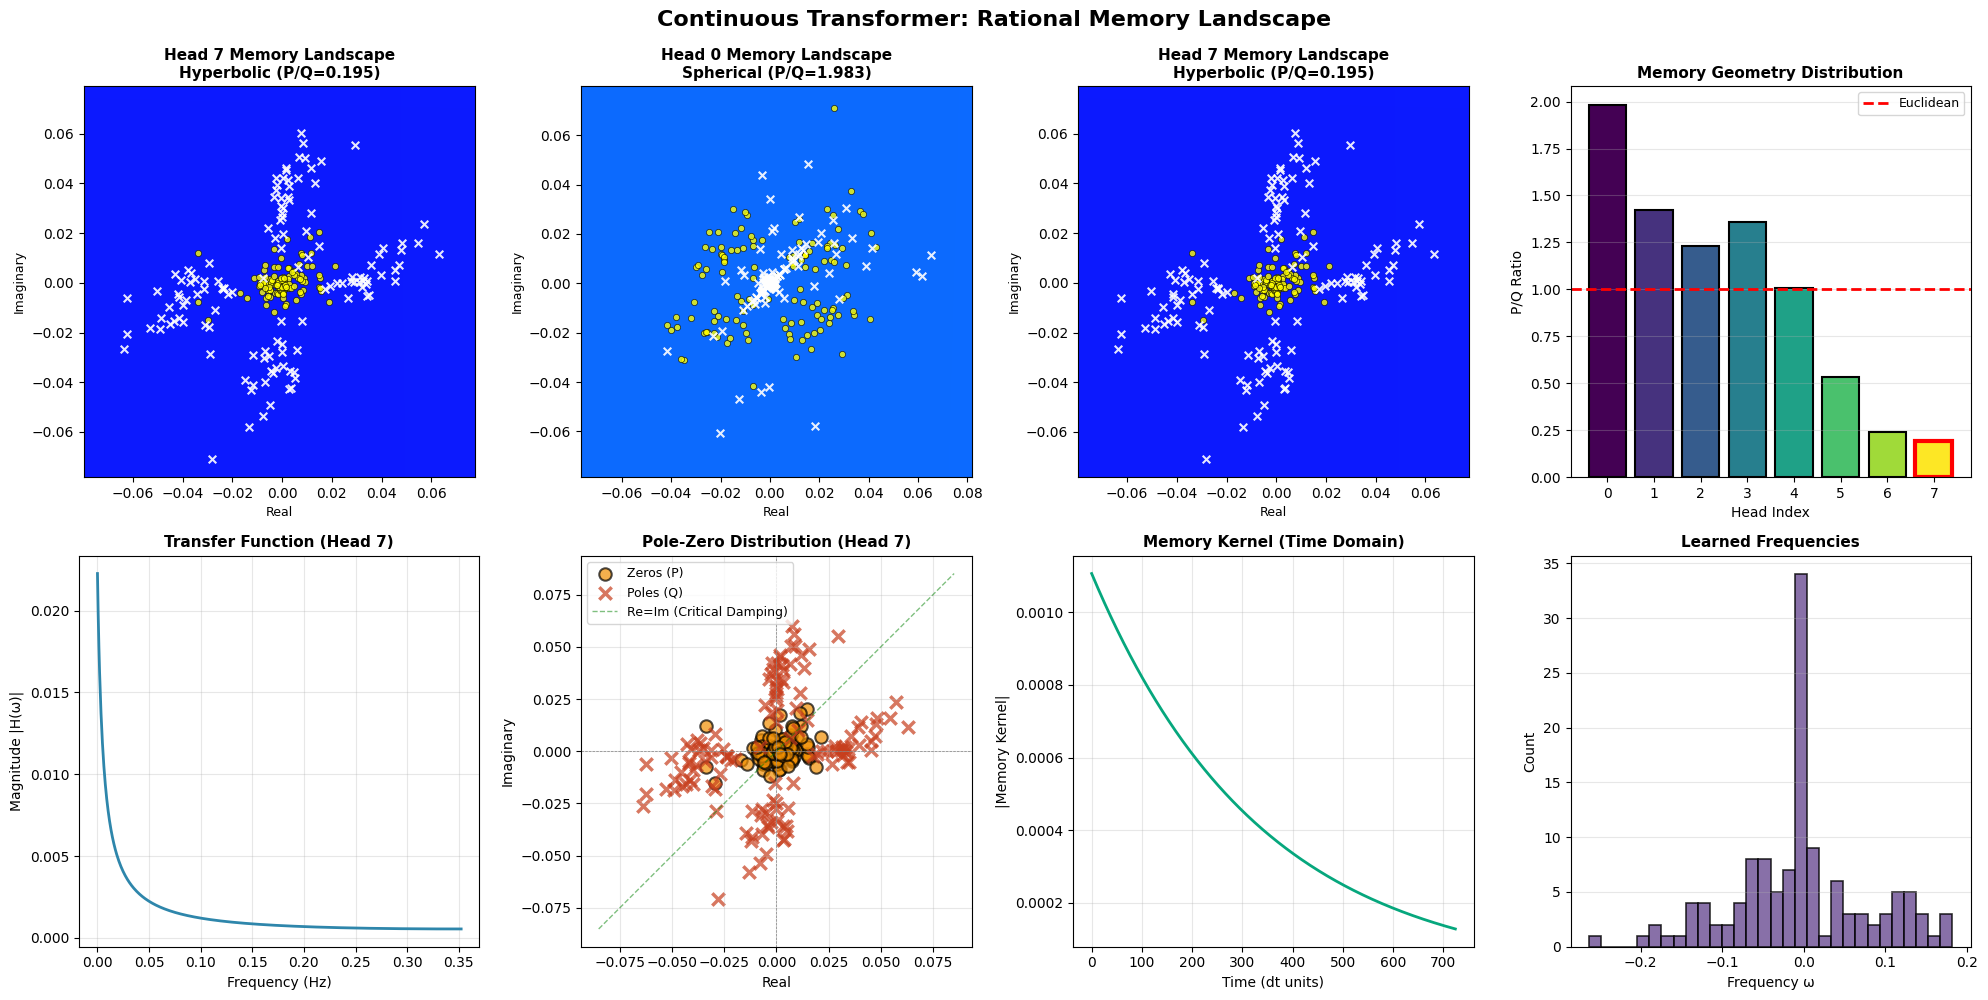

  Checkpoint saved: continuous_transformer_step01000.pt

Step 01100 (Epoch 0, Batch 1100/4351072) | Loss: 0.6860 | Acc: 78.5% | LR: 1.69e-04 | dt: 1.418 | P/Q: 0.776
Step 01200 (Epoch 0, Batch 1200/4351072) | Loss: 0.6970 | Acc: 78.2% | LR: 1.65e-04 | dt: 1.416 | P/Q: 0.772
Step 01300 (Epoch 0, Batch 1300/4351072) | Loss: 0.6845 | Acc: 78.8% | LR: 1.75e-04 | dt: 1.416 | P/Q: 0.764
Step 01400 (Epoch 0, Batch 1400/4351072) | Loss: 0.7559 | Acc: 77.3% | LR: 1.66e-04 | dt: 1.416 | P/Q: 0.761
Step 01500 (Epoch 0, Batch 1500/4351072) | Loss: 0.7988 | Acc: 75.7% | LR: 1.70e-04 | dt: 1.417 | P/Q: 0.754
Step 01600 (Epoch 0, Batch 1600/4351072) | Loss: 0.7684 | Acc: 75.2% | LR: 1.63e-04 | dt: 1.418 | P/Q: 0.749
Step 01700 (Epoch 0, Batch 1700/4351072) | Loss: 0.7850 | Acc: 76.1% | LR: 1.67e-04 | dt: 1.418 | P/Q: 0.748
Step 01800 (Epoch 0, Batch 1800/4351072) | Loss: 0.6470 | Acc: 79.2% | LR: 1.70e-04 | dt: 1.419 | P/Q: 0.742
Step 01900 (Epoch 0, Batch 1900/4351072) | Loss: 0.5900 | Acc: 81.6% | 

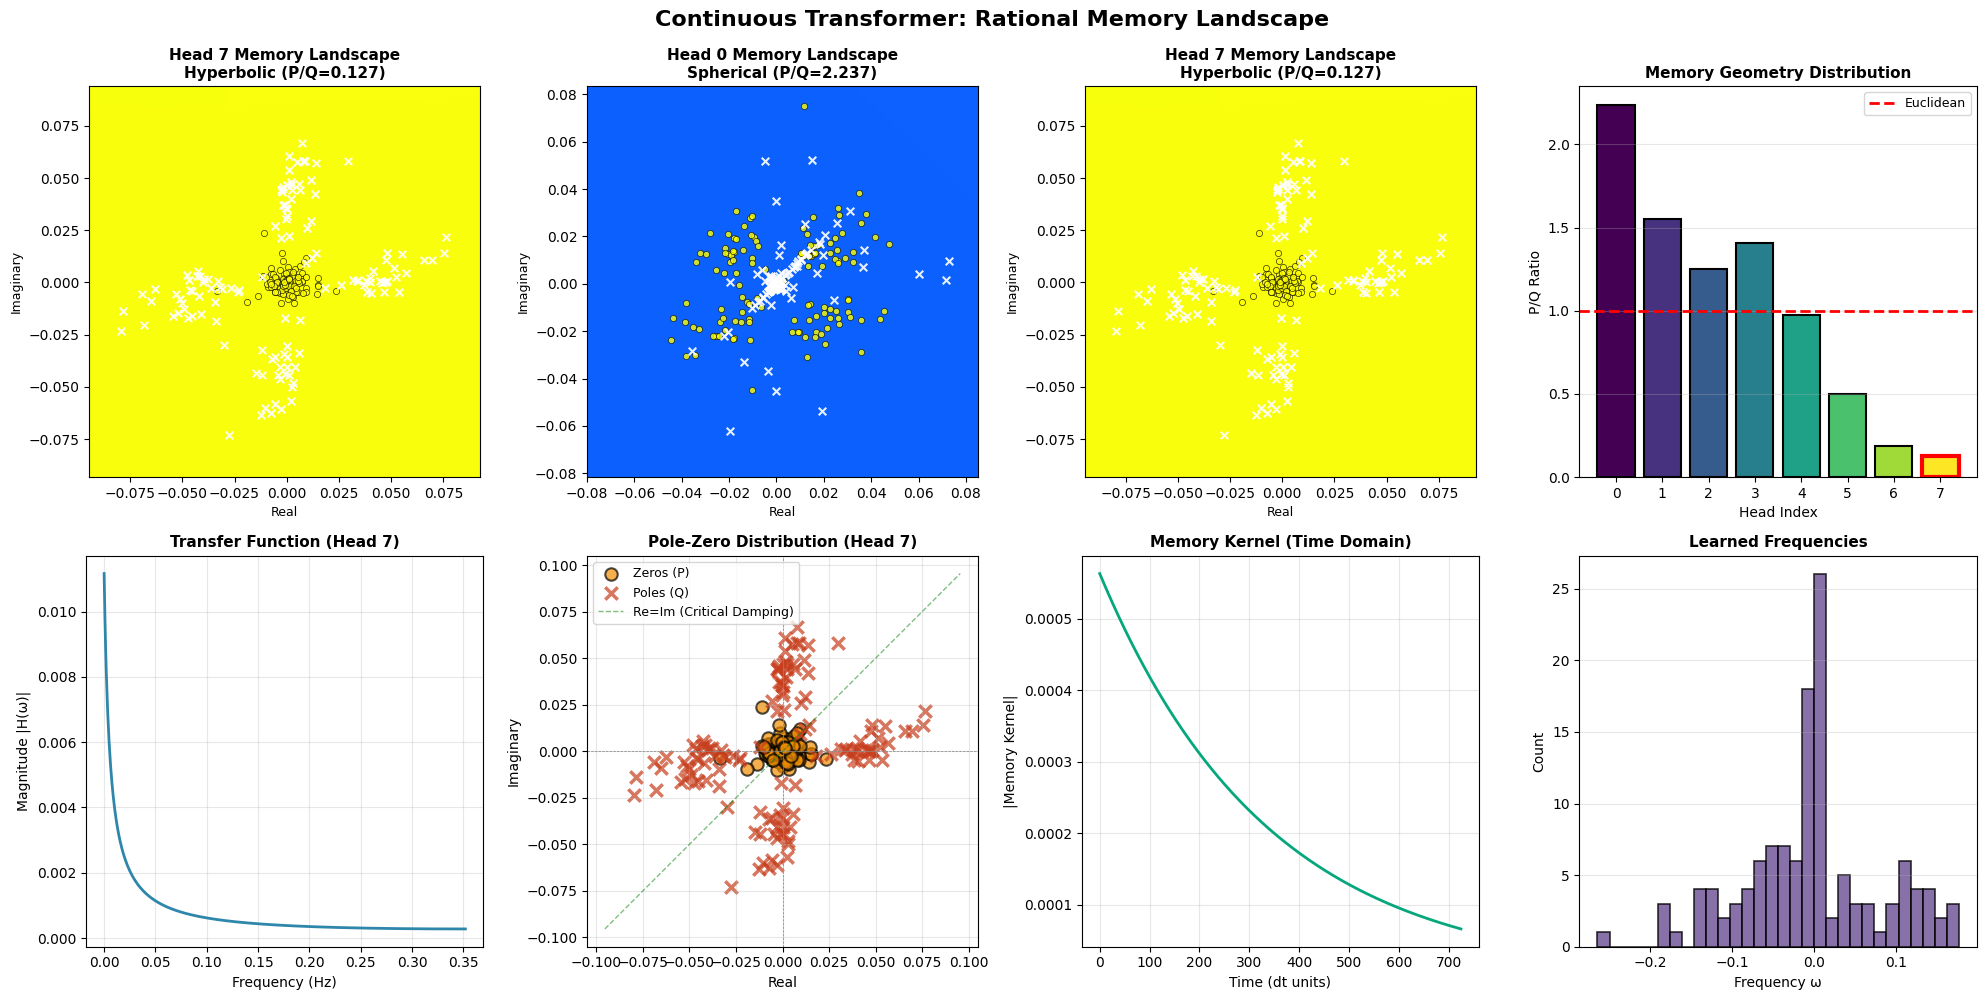

  Checkpoint saved: continuous_transformer_step02000.pt

Step 02100 (Epoch 0, Batch 2100/4351072) | Loss: 0.6721 | Acc: 78.4% | LR: 1.69e-04 | dt: 1.418 | P/Q: 0.731
Step 02200 (Epoch 0, Batch 2200/4351072) | Loss: 0.6606 | Acc: 79.1% | LR: 1.81e-04 | dt: 1.419 | P/Q: 0.729
Step 02300 (Epoch 0, Batch 2300/4351072) | Loss: 0.6673 | Acc: 78.0% | LR: 1.69e-04 | dt: 1.419 | P/Q: 0.727
Step 02400 (Epoch 0, Batch 2400/4351072) | Loss: 0.6944 | Acc: 78.0% | LR: 1.68e-04 | dt: 1.419 | P/Q: 0.723
Step 02500 (Epoch 0, Batch 2500/4351072) | Loss: 0.5843 | Acc: 81.4% | LR: 1.78e-04 | dt: 1.419 | P/Q: 0.721
Step 02600 (Epoch 0, Batch 2600/4351072) | Loss: 0.6195 | Acc: 80.1% | LR: 1.69e-04 | dt: 1.418 | P/Q: 0.716
Step 02700 (Epoch 0, Batch 2700/4351072) | Loss: 0.9580 | Acc: 71.2% | LR: 1.63e-04 | dt: 1.419 | P/Q: 0.715
Step 02800 (Epoch 0, Batch 2800/4351072) | Loss: 0.6888 | Acc: 78.0% | LR: 1.60e-04 | dt: 1.418 | P/Q: 0.709
Step 02900 (Epoch 0, Batch 2900/4351072) | Loss: 0.7546 | Acc: 75.9% | 

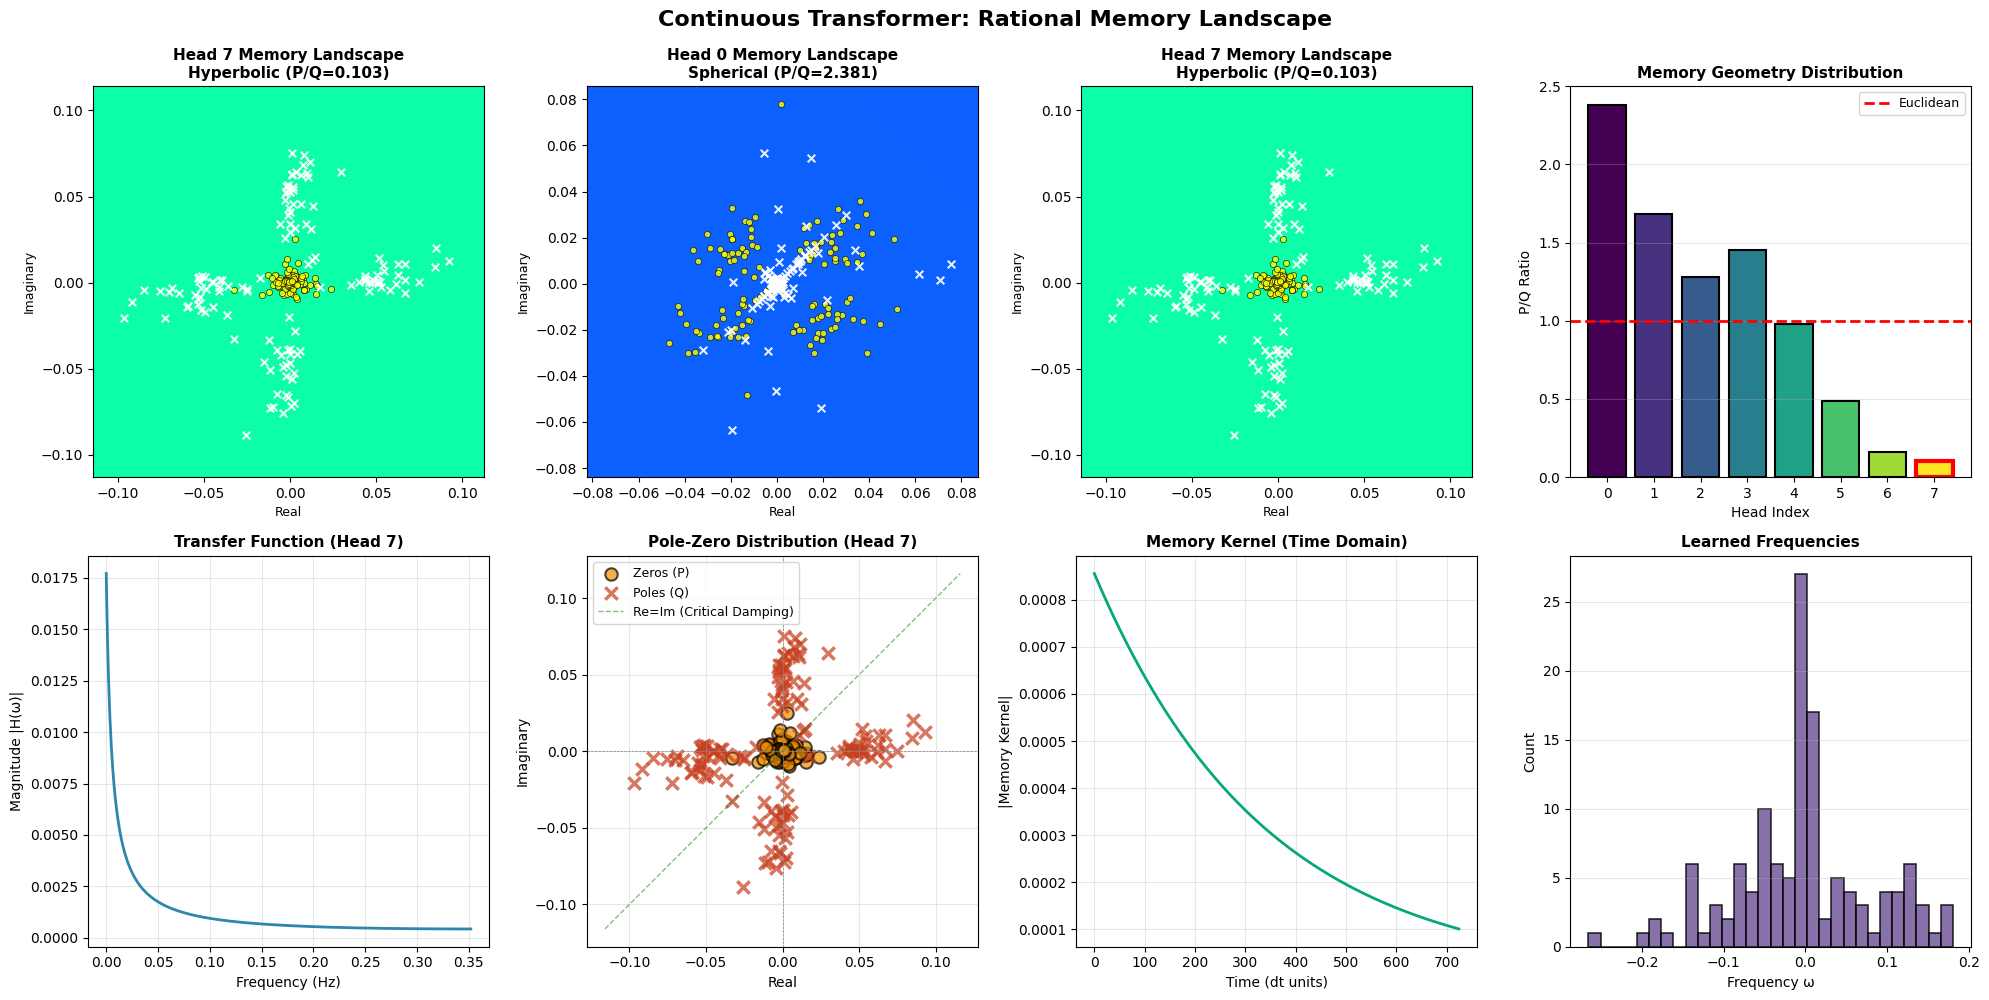

  Checkpoint saved: continuous_transformer_step03000.pt

Step 03100 (Epoch 0, Batch 3100/4351072) | Loss: 0.6063 | Acc: 80.8% | LR: 1.68e-04 | dt: 1.418 | P/Q: 0.702
Step 03200 (Epoch 0, Batch 3200/4351072) | Loss: 0.6556 | Acc: 79.5% | LR: 1.66e-04 | dt: 1.419 | P/Q: 0.701
Step 03300 (Epoch 0, Batch 3300/4351072) | Loss: 0.5893 | Acc: 81.5% | LR: 1.79e-04 | dt: 1.419 | P/Q: 0.699
Step 03400 (Epoch 0, Batch 3400/4351072) | Loss: 0.7103 | Acc: 76.6% | LR: 1.56e-04 | dt: 1.419 | P/Q: 0.694
Step 03500 (Epoch 0, Batch 3500/4351072) | Loss: 0.6299 | Acc: 79.9% | LR: 1.73e-04 | dt: 1.419 | P/Q: 0.693
Step 03600 (Epoch 0, Batch 3600/4351072) | Loss: 0.8349 | Acc: 74.2% | LR: 1.80e-04 | dt: 1.419 | P/Q: 0.692
Step 03700 (Epoch 0, Batch 3700/4351072) | Loss: 0.6569 | Acc: 79.2% | LR: 1.56e-04 | dt: 1.418 | P/Q: 0.686
Step 03800 (Epoch 0, Batch 3800/4351072) | Loss: 0.8163 | Acc: 74.6% | LR: 1.53e-04 | dt: 1.418 | P/Q: 0.686
Step 03900 (Epoch 0, Batch 3900/4351072) | Loss: 0.7719 | Acc: 75.8% | 

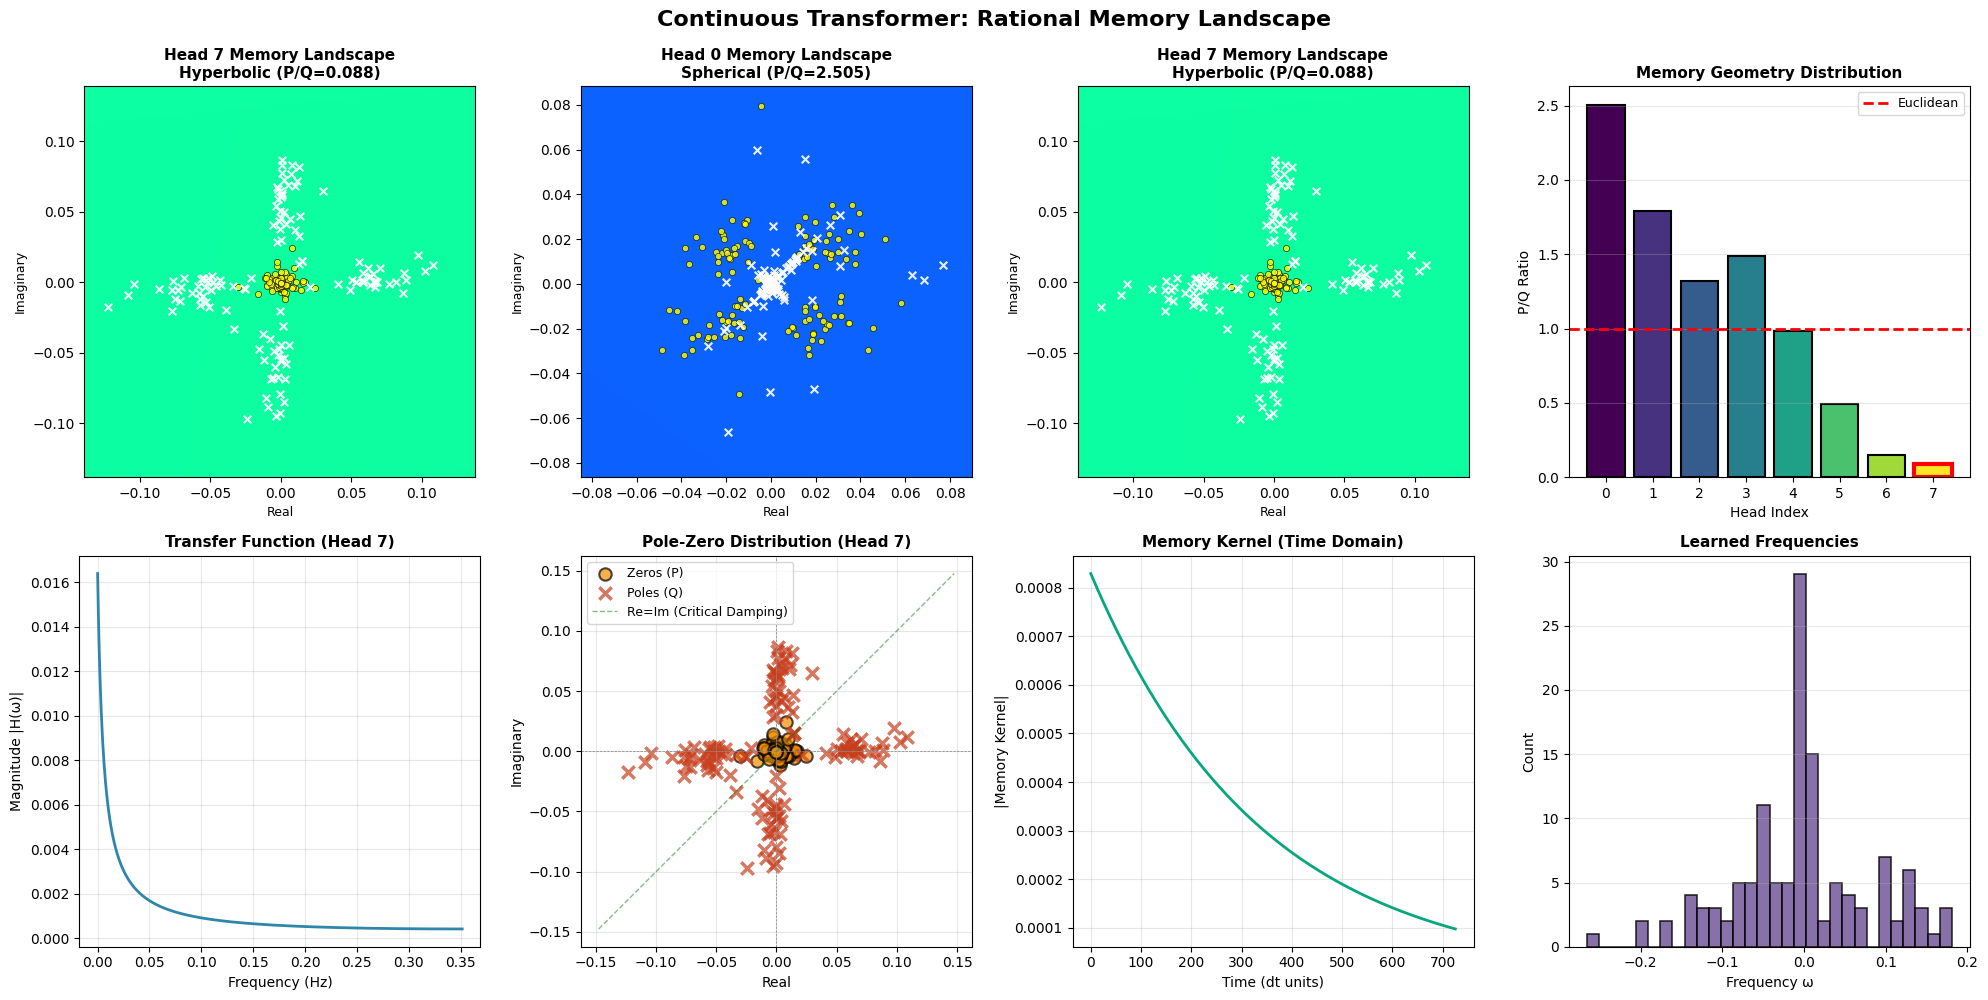

  Checkpoint saved: continuous_transformer_step04000.pt

Step 04100 (Epoch 0, Batch 4100/4351072) | Loss: 0.6944 | Acc: 77.6% | LR: 1.67e-04 | dt: 1.419 | P/Q: 0.677
Step 04200 (Epoch 0, Batch 4200/4351072) | Loss: 0.7100 | Acc: 77.7% | LR: 1.69e-04 | dt: 1.420 | P/Q: 0.675
Step 04300 (Epoch 0, Batch 4300/4351072) | Loss: 0.6046 | Acc: 80.3% | LR: 1.63e-04 | dt: 1.419 | P/Q: 0.674
Step 04400 (Epoch 0, Batch 4400/4351072) | Loss: 0.6872 | Acc: 78.3% | LR: 1.60e-04 | dt: 1.421 | P/Q: 0.671
Step 04500 (Epoch 0, Batch 4500/4351072) | Loss: 0.7665 | Acc: 76.3% | LR: 1.64e-04 | dt: 1.420 | P/Q: 0.671
Step 04600 (Epoch 0, Batch 4600/4351072) | Loss: 0.6396 | Acc: 79.7% | LR: 1.65e-04 | dt: 1.421 | P/Q: 0.668
Step 04700 (Epoch 0, Batch 4700/4351072) | Loss: 0.5827 | Acc: 81.0% | LR: 1.82e-04 | dt: 1.420 | P/Q: 0.668
Step 04800 (Epoch 0, Batch 4800/4351072) | Loss: 0.6434 | Acc: 78.8% | LR: 1.67e-04 | dt: 1.420 | P/Q: 0.664
Step 04900 (Epoch 0, Batch 4900/4351072) | Loss: 0.6007 | Acc: 81.0% | 

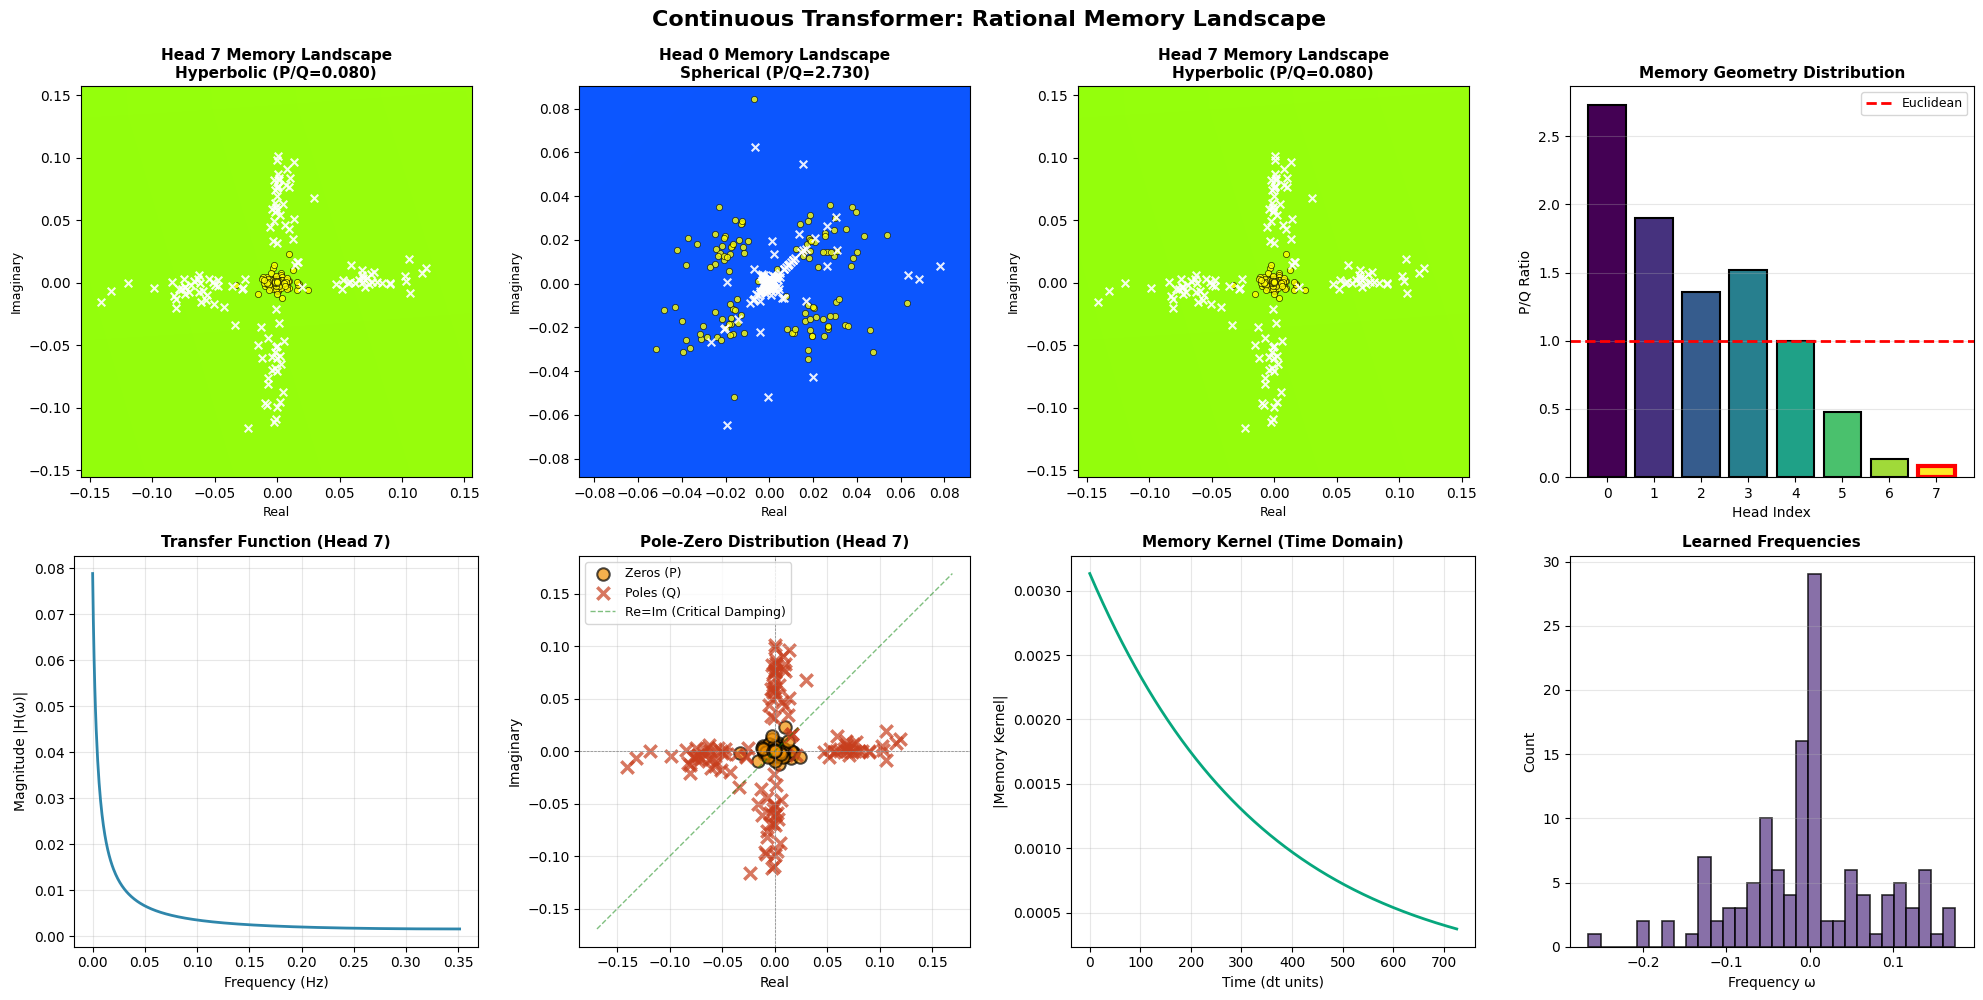

  Checkpoint saved: continuous_transformer_step05000.pt

Step 05100 (Epoch 0, Batch 5100/4351072) | Loss: 0.7099 | Acc: 77.9% | LR: 1.76e-04 | dt: 1.422 | P/Q: 0.656
Step 05200 (Epoch 0, Batch 5200/4351072) | Loss: 0.5728 | Acc: 81.7% | LR: 1.76e-04 | dt: 1.422 | P/Q: 0.653
Step 05300 (Epoch 0, Batch 5300/4351072) | Loss: 0.6441 | Acc: 80.1% | LR: 1.82e-04 | dt: 1.421 | P/Q: 0.652
Step 05400 (Epoch 0, Batch 5400/4351072) | Loss: 0.8176 | Acc: 74.7% | LR: 1.68e-04 | dt: 1.422 | P/Q: 0.650
Step 05500 (Epoch 0, Batch 5500/4351072) | Loss: 0.5828 | Acc: 81.8% | LR: 1.62e-04 | dt: 1.422 | P/Q: 0.650
Step 05600 (Epoch 0, Batch 5600/4351072) | Loss: 0.6210 | Acc: 80.4% | LR: 1.70e-04 | dt: 1.422 | P/Q: 0.646
Step 05700 (Epoch 0, Batch 5700/4351072) | Loss: 0.6880 | Acc: 78.7% | LR: 1.68e-04 | dt: 1.423 | P/Q: 0.646
Step 05800 (Epoch 0, Batch 5800/4351072) | Loss: 0.5815 | Acc: 81.1% | LR: 1.75e-04 | dt: 1.422 | P/Q: 0.643
Step 05900 (Epoch 0, Batch 5900/4351072) | Loss: 0.6415 | Acc: 80.6% | 

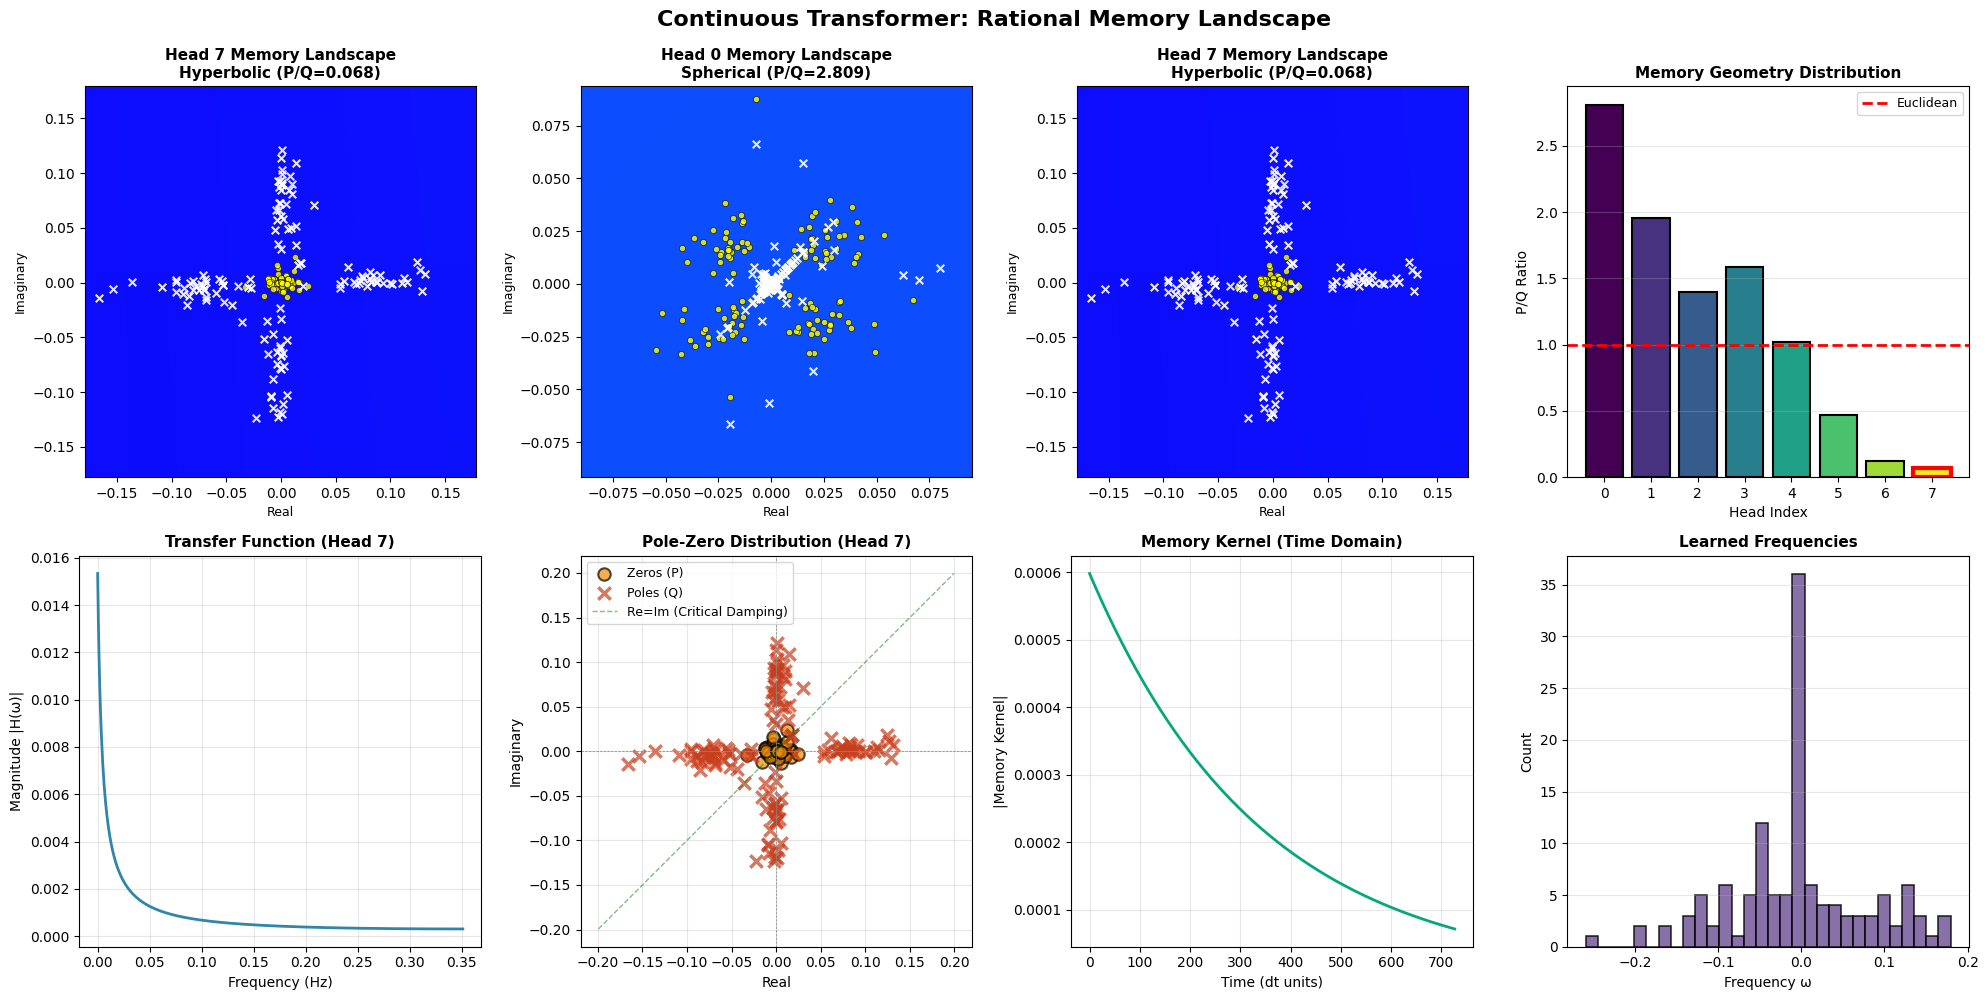

  Checkpoint saved: continuous_transformer_step06000.pt

Step 06100 (Epoch 0, Batch 6100/4351072) | Loss: 0.6212 | Acc: 81.4% | LR: 1.85e-04 | dt: 1.422 | P/Q: 0.640
Step 06200 (Epoch 0, Batch 6200/4351072) | Loss: 0.7267 | Acc: 77.5% | LR: 1.59e-04 | dt: 1.421 | P/Q: 0.638
Step 06300 (Epoch 0, Batch 6300/4351072) | Loss: 0.7429 | Acc: 77.1% | LR: 1.67e-04 | dt: 1.422 | P/Q: 0.636
Step 06400 (Epoch 0, Batch 6400/4351072) | Loss: 0.6294 | Acc: 79.3% | LR: 1.74e-04 | dt: 1.422 | P/Q: 0.634
Step 06500 (Epoch 0, Batch 6500/4351072) | Loss: 0.5816 | Acc: 81.1% | LR: 1.73e-04 | dt: 1.422 | P/Q: 0.633
Step 06600 (Epoch 0, Batch 6600/4351072) | Loss: 0.7348 | Acc: 77.1% | LR: 1.77e-04 | dt: 1.422 | P/Q: 0.630
Step 06700 (Epoch 0, Batch 6700/4351072) | Loss: 0.6843 | Acc: 78.5% | LR: 1.80e-04 | dt: 1.425 | P/Q: 0.629
Step 06800 (Epoch 0, Batch 6800/4351072) | Loss: 0.6939 | Acc: 77.9% | LR: 1.79e-04 | dt: 1.426 | P/Q: 0.625
Step 06900 (Epoch 0, Batch 6900/4351072) | Loss: 0.6392 | Acc: 79.9% | 

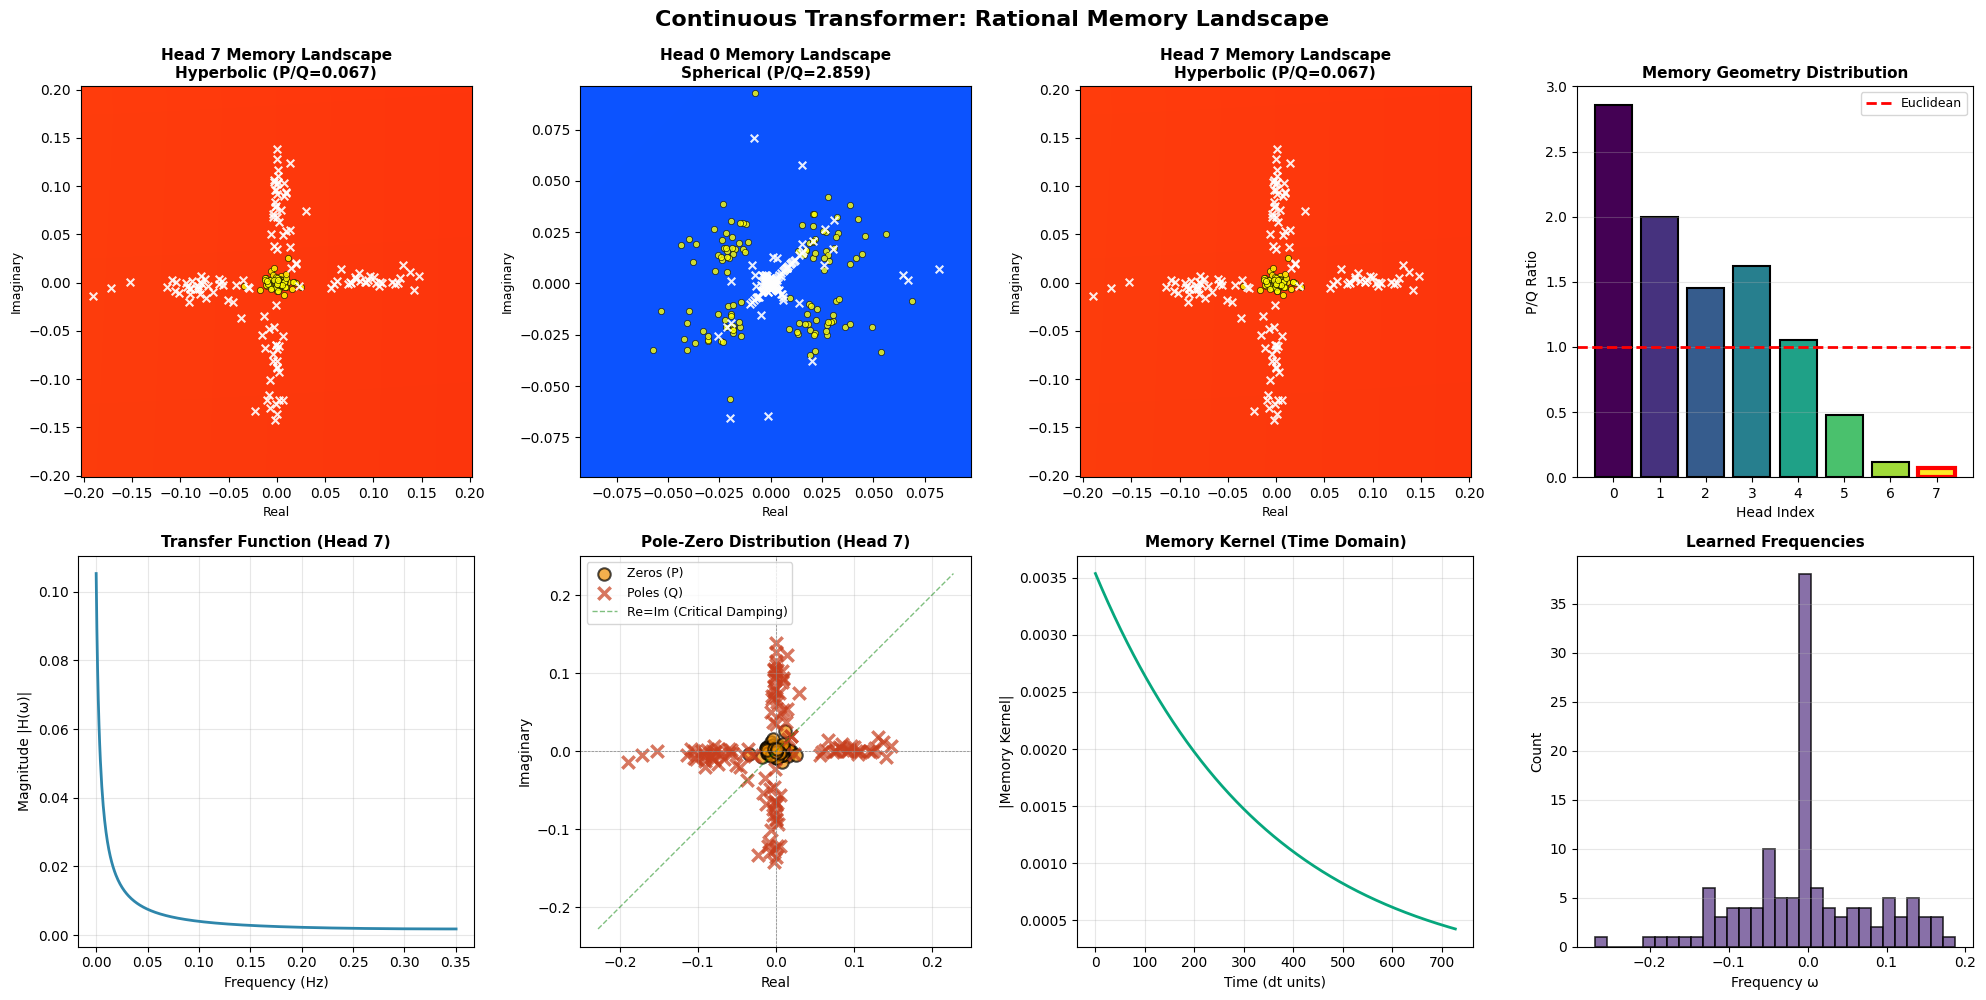

  Checkpoint saved: continuous_transformer_step07000.pt

Step 07100 (Epoch 0, Batch 7100/4351072) | Loss: 0.6793 | Acc: 78.6% | LR: 1.70e-04 | dt: 1.426 | P/Q: 0.621
Step 07200 (Epoch 0, Batch 7200/4351072) | Loss: 0.6335 | Acc: 80.6% | LR: 1.79e-04 | dt: 1.425 | P/Q: 0.621
Step 07300 (Epoch 0, Batch 7300/4351072) | Loss: 0.6355 | Acc: 79.7% | LR: 1.72e-04 | dt: 1.424 | P/Q: 0.618
Step 07400 (Epoch 0, Batch 7400/4351072) | Loss: 0.6489 | Acc: 79.3% | LR: 1.59e-04 | dt: 1.423 | P/Q: 0.618
Step 07500 (Epoch 0, Batch 7500/4351072) | Loss: 0.6356 | Acc: 80.3% | LR: 1.73e-04 | dt: 1.424 | P/Q: 0.615
Step 07600 (Epoch 0, Batch 7600/4351072) | Loss: 0.6136 | Acc: 80.7% | LR: 1.85e-04 | dt: 1.425 | P/Q: 0.612
Step 07700 (Epoch 0, Batch 7700/4351072) | Loss: 0.5536 | Acc: 82.6% | LR: 1.84e-04 | dt: 1.424 | P/Q: 0.612
Step 07800 (Epoch 0, Batch 7800/4351072) | Loss: 0.5229 | Acc: 83.3% | LR: 1.76e-04 | dt: 1.424 | P/Q: 0.611
Step 07900 (Epoch 0, Batch 7900/4351072) | Loss: 0.7821 | Acc: 75.8% | 

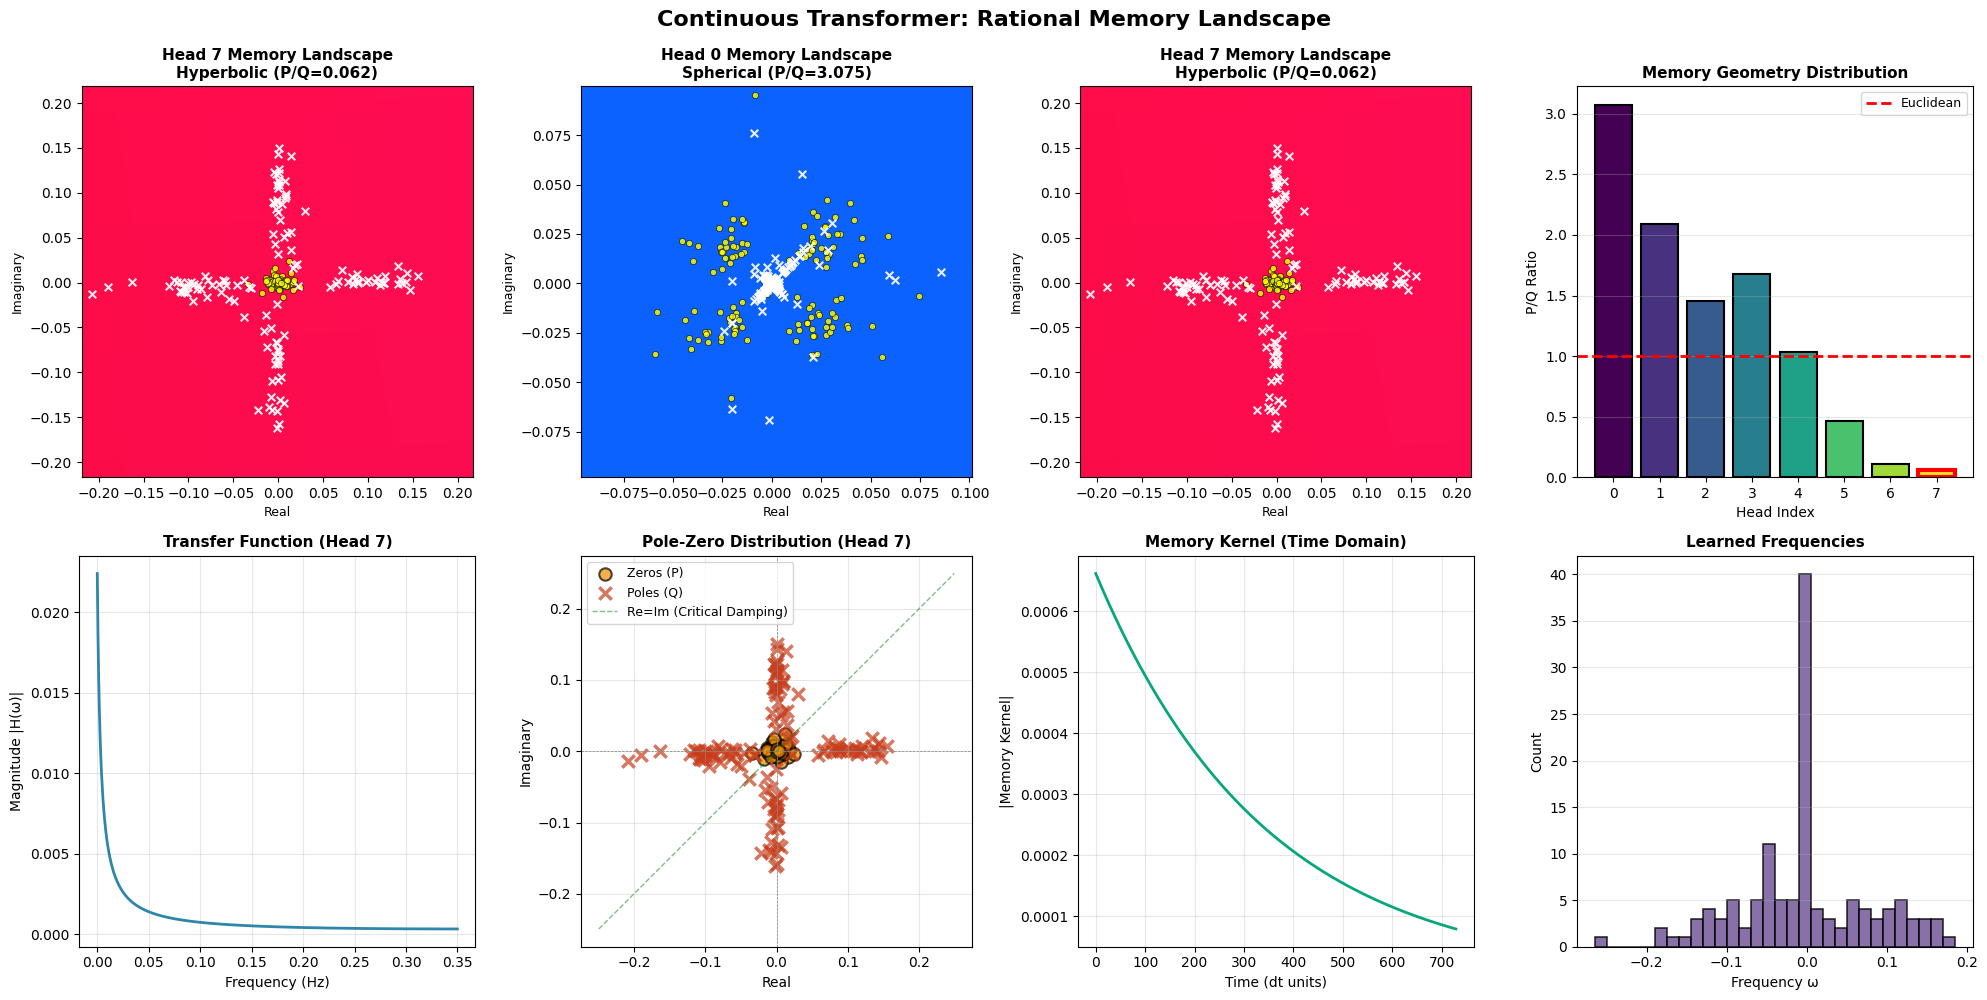

  Checkpoint saved: continuous_transformer_step08000.pt

Step 08100 (Epoch 0, Batch 8100/4351072) | Loss: 0.6388 | Acc: 79.9% | LR: 1.66e-04 | dt: 1.426 | P/Q: 0.606
Step 08200 (Epoch 0, Batch 8200/4351072) | Loss: 0.6643 | Acc: 79.0% | LR: 1.73e-04 | dt: 1.426 | P/Q: 0.605
Step 08300 (Epoch 0, Batch 8300/4351072) | Loss: 0.5682 | Acc: 82.0% | LR: 1.76e-04 | dt: 1.426 | P/Q: 0.603
Step 08400 (Epoch 0, Batch 8400/4351072) | Loss: 0.6448 | Acc: 79.1% | LR: 1.73e-04 | dt: 1.426 | P/Q: 0.601


In [ ]:
step = start_step
try:
    while True:
        for batch_idx, (x, y) in enumerate(dataloader):
            x = x.to(device)  # [B, L]
            y = y.to(device)  # [B, L]
            
            # Forward pass
            logits, _ = model(x)  # [B, L, V]
            loss = nn.CrossEntropyLoss()(logits.view(-1, VOCAB_SIZE), y.view(-1))
            
            # Backward pass
            opt.zero_grad()
            loss.backward()
            
            # Homeostatic learning rate adjustment
            with torch.no_grad():
                # Compute gradient statistics
                grad_norm = sum(p.grad.norm()**2 for p in model.parameters() if p.grad is not None)**0.5
                
                # Update exponential moving average of loss
                if ema_loss is None: 
                    ema_loss = loss.item()
                ema_loss = 0.95 * ema_loss + 0.05 * loss.item()
                
                # Adaptive learning rate based on gradient stability
                stability = 1.0 / (grad_norm.item() + 1e-6)
                reactive_lr = BASE_LR / (1.0 + np.exp(-(stability - 0.5)))
                
                # Update optimizer learning rate
                for param_group in opt.param_groups:
                    param_group['lr'] = reactive_lr
            
            # Gradient clipping and optimization step
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            opt.step()
            
            # Logging
            if step % PRINT_EVERY == 0:
                acc = (logits.argmax(-1) == y).float().mean()
                epoch = step // len(dataloader)
                batch_in_epoch = step % len(dataloader)
                
                # Track P/Q ratio
                with torch.no_grad():
                    sqrt2_inv = 0.7071067811865476
                    P_real = (model.P_radial + model.P_deviation) * sqrt2_inv
                    P_imag = (model.P_radial - model.P_deviation) * sqrt2_inv
                    Q_real = (model.Q_radial + model.Q_deviation) * sqrt2_inv
                    Q_imag = (model.Q_radial - model.Q_deviation) * sqrt2_inv
                    P_mag = (P_real**2 + P_imag**2).sqrt().mean().item()
                    Q_mag = (Q_real**2 + Q_imag**2).sqrt().mean().item()
                    curvature = P_mag / (Q_mag + 1e-6)
                
                print(f"Step {step:05d} (Epoch {epoch}, Batch {batch_in_epoch}/{len(dataloader)}) | Loss: {loss.item():.4f} | Acc: {acc.item()*100:.1f}% | LR: {reactive_lr:.2e} | dt: {model.dt.item():.3f} | P/Q: {curvature:.3f}")
            
            # Checkpointing and generation
            if step % CHECKPOINT_EVERY == 0 and step > start_step:
                generate(model, "Once upon a time", device=device)
                
                # Visualize spectral dynamics
                print("\n" + "="*60)
                print("ANALYZING SPECTRAL DYNAMICS...")
                print("="*60)
                visualize_spectral_dynamics(model, device=device, seq_len=512)
                
                torch.save(model.state_dict(), f"continuous_transformer_step{step:05d}.pt")
                print(f"  Checkpoint saved: continuous_transformer_step{step:05d}.pt\n")
            
            step += 1
        
except KeyboardInterrupt:
    print("\nTraining interrupted by user")
    print(f"Final step: {step}")
    
    # Save final checkpoint
    final_checkpoint = f"continuous_transformer_step{step:05d}.pt"
    torch.save(model.state_dict(), final_checkpoint)
    print(f"Final checkpoint saved: {final_checkpoint}")

## References

- **A Mathematical Explanation of Transformers for Large Language Models and GPTs** - Tai et al. (2024). [arXiv:2510.03989](https://arxiv.org/abs/2510.03989)
- **HiPPO: Recurrent Memory with Optimal Polynomial Projections** - Gu et al. (2020). NeurIPS. [arXiv:2008.07669](https://arxiv.org/abs/2008.07669)
- **Efficiently Modeling Long Sequences with Structured State Spaces (S4)** - Gu et al. (2022). ICLR. [arXiv:2111.00396](https://arxiv.org/abs/2111.00396)
- **Neural Ordinary Differential Equations** - Chen et al. (2018). NeurIPS. [arXiv:1806.07366](https://arxiv.org/abs/1806.07366)
- **Deep Complex Networks** - Trabelsi et al. (2017). ICLR. [arXiv:1705.09792](https://arxiv.org/abs/1705.09792)
- **FNet: Mixing Tokens with Fourier Transforms** - Lee-Thorp et al. (2021). NAACL. [arXiv:2105.03824](https://arxiv.org/abs/2105.03824)
- **Language Modeling with Gated Convolutional Networks** - Dauphin et al. (2017). ICML. [arXiv:1612.08083](https://arxiv.org/abs/1612.08083)
- **Informer: Beyond Efficient Transformer for Long Sequence Time-Series Forecasting** - Zhou et al. (2021). AAAI. [arXiv:2012.07436](https://arxiv.org/abs/2012.07436)
- **Liquid Time-constant Networks** - Hasani et al. (2020). AAAI. [arXiv:2006.04439](https://arxiv.org/abs/2006.04439)
- **TinyStories: How Small Can Language Models Be and Still Speak Coherent English?** - Eldan & Li (2023). [arXiv:2305.07759](https://arxiv.org/abs/2305.07759)